In [1]:
#pip install -qq transformers

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

numpy       : 1.19.2
pandas      : 1.1.3
torch       : 1.7.1
transformers: 2.6.0



In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
from matplotlib import rc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette = 'muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


RANDOM_SEED= 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

C:\Anaconda\lib\site-packages\torch\cuda\__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: D:\Fine-Tuning-BERT-For-Sentiment-Analysis-Served-With-fastAPI\notebooks\apps.csv

  0%|          | 0.00/134k [00:00<?, ?B/s]
100%|##########| 134k/134k [00:00<00:00, 768kB/s]
100%|##########| 134k/134k [00:00<00:00, 764kB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: D:\Fine-Tuning-BERT-For-Sentiment-Analysis-Served-With-fastAPI\notebooks\reviews.csv

0.00B [00:00, ?B/s]
524kB [00:00, 1.73MB/s]
1.57MB [00:00, 2.23MB/s]
2.62MB [00:00, 2.84MB/s]
3.15MB [00:00, 2.64MB/s]
4.19MB [00:01, 2.67MB/s]
6.29MB [00:01, 3.50MB/s]
7.17MB [00:01, 3.78MB/s]
7.17MB [00:01, 4.61MB/s]


In [5]:
df = pd.read_csv('reviews.csv')
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo
1,Craig Haines,https://lh3.googleusercontent.com/-hoe0kwSJgPQ...,Used it for a fair amount of time without any ...,1,11,4.17.0.3,2020-04-04 13:40:01,It sounds like you logged in with a different ...,2020-04-05 15:11:35,most_relevant,com.anydo
2,steven adkins,https://lh3.googleusercontent.com/a-/AOh14GiXw...,Your app sucks now!!!!! Used to be good but no...,1,17,4.17.0.3,2020-04-01 16:18:13,This sounds odd! We are not aware of any issue...,2020-04-02 16:05:56,most_relevant,com.anydo
3,Lars Panzerbjørn,https://lh3.googleusercontent.com/a-/AOh14Gg-h...,"It seems OK, but very basic. Recurring tasks n...",1,192,4.17.0.2,2020-03-12 08:17:34,We do offer this option as part of the Advance...,2020-03-15 06:20:13,most_relevant,com.anydo
4,Scott Prewitt,https://lh3.googleusercontent.com/-K-X1-YsVd6U...,Absolutely worthless. This app runs a prohibit...,1,42,4.17.0.2,2020-03-14 17:41:01,We're sorry you feel this way! 90% of the app ...,2020-03-15 23:45:51,most_relevant,com.anydo


In [6]:
df.shape

(15746, 11)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15746 entries, 0 to 15745
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   userName              15746 non-null  object
 1   userImage             15746 non-null  object
 2   content               15746 non-null  object
 3   score                 15746 non-null  int64 
 4   thumbsUpCount         15746 non-null  int64 
 5   reviewCreatedVersion  13533 non-null  object
 6   at                    15746 non-null  object
 7   replyContent          7367 non-null   object
 8   repliedAt             7367 non-null   object
 9   sortOrder             15746 non-null  object
 10  appId                 15746 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.3+ MB


<AxesSubplot:xlabel='score', ylabel='count'>

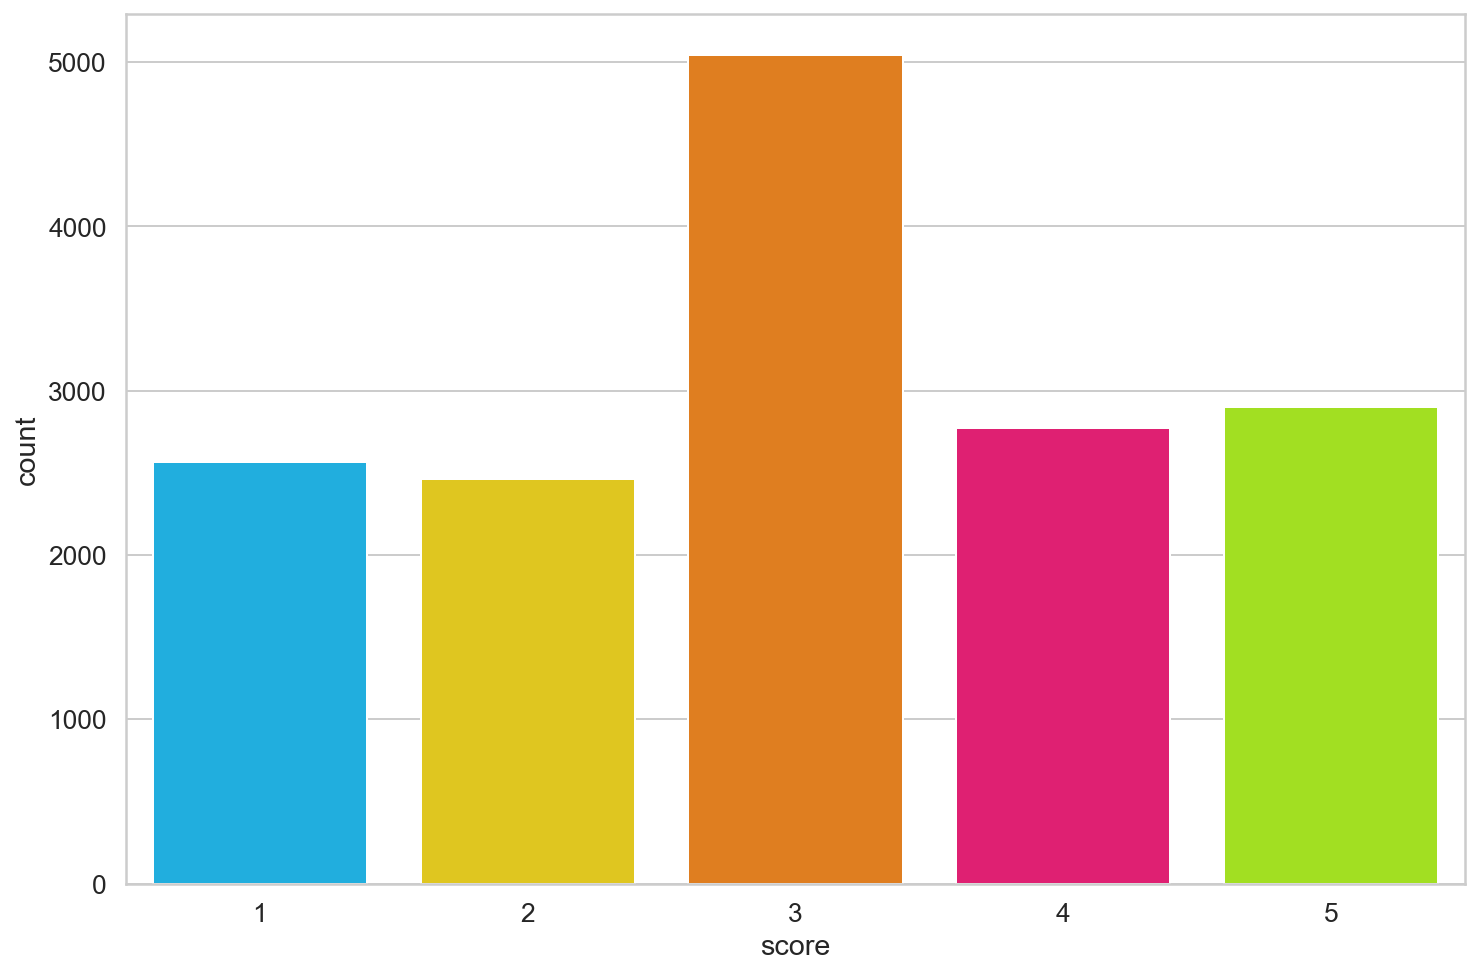

In [8]:
sns.countplot(df.score)

In [9]:
def to_sentiment(rating):
    rating = int(rating)
    if rating <= 2:
        return 0
    elif rating == 3:
        return 1
    else:
        return 2
df['sentiment'] = df.score.apply(to_sentiment)

In [10]:
class_names = ['negative', 'neutral', 'positive']

[Text(0, 0, 'negative'), Text(1, 0, 'neutral'), Text(2, 0, 'positive')]

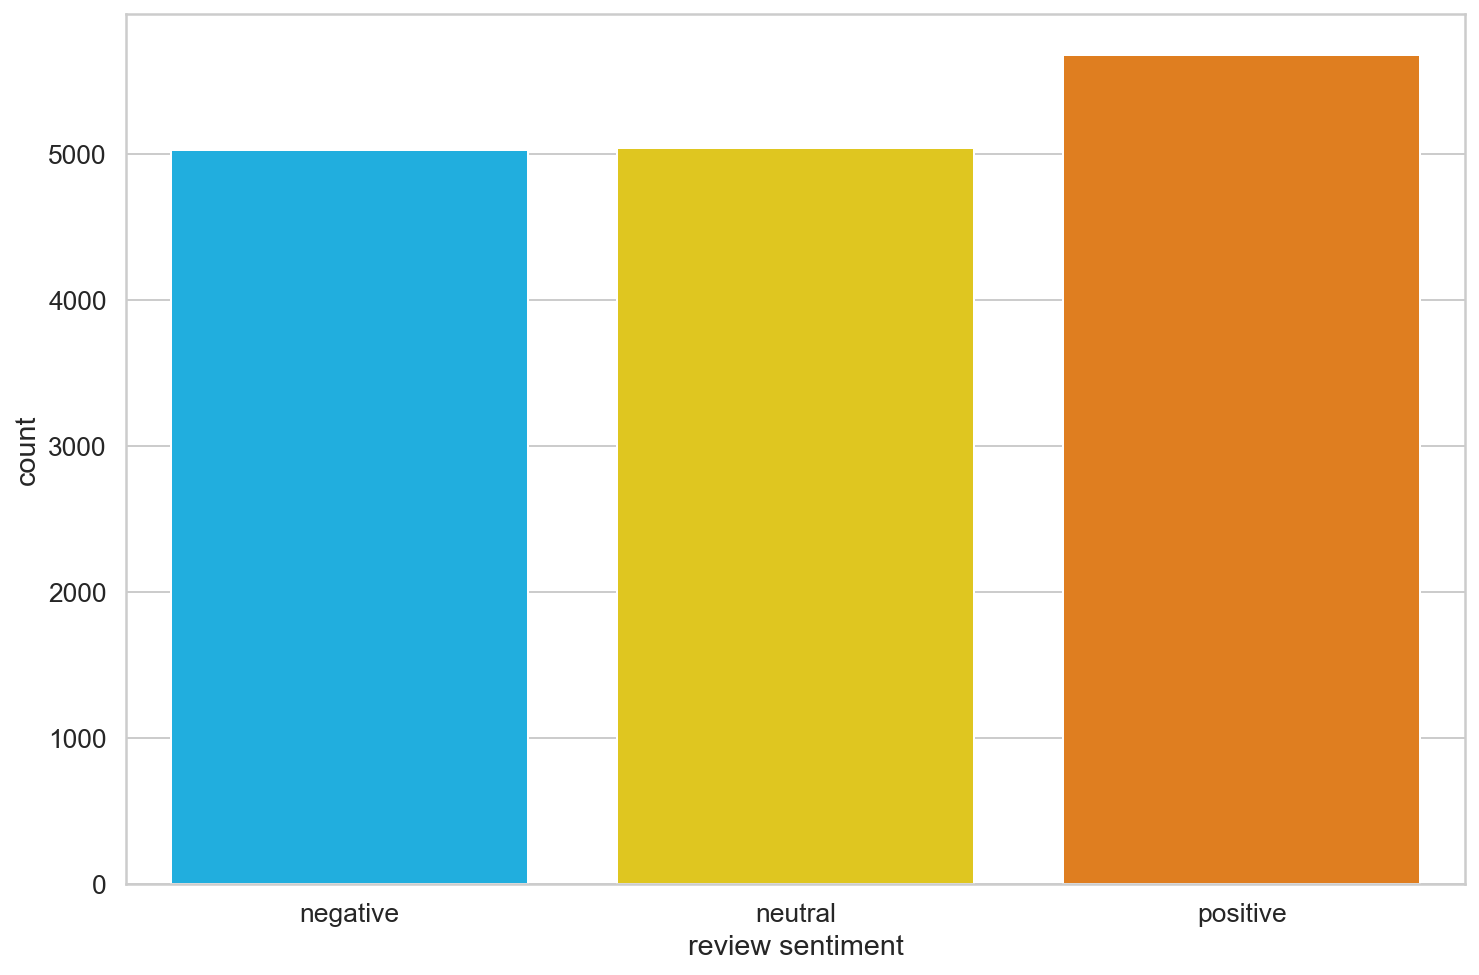

In [11]:
ax = sns.countplot(df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [13]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [14]:
sample_text = 'when was I last outside? I am stuck at home for 2 weeks'

In [15]:
tokens = tokenizer.tokenize(sample_text)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence : {sample_text}')
print(f'Tokens : {tokens}')
print(f'Tokens IDs : {token_ids}')

Sentence : when was I last outside? I am stuck at home for 2 weeks
Tokens : ['when', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks']
Tokens IDs : [1165, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277]


In [16]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

In [17]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

In [18]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

In [19]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

In [20]:
encoding = tokenizer.encode_plus(
    sample_text,
    max_length=32,
    add_special_tokens=True, # Add '[CLS]' and '[SEP]'
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [21]:
print(len(encoding['input_ids'][0]))

32


In [22]:
encoding['input_ids'][0]

tensor([ 101, 1165, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [23]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [24]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'when',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [25]:
token_lens = []
for txt in df.content:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))

Text(0.5, 0, 'Token Count')

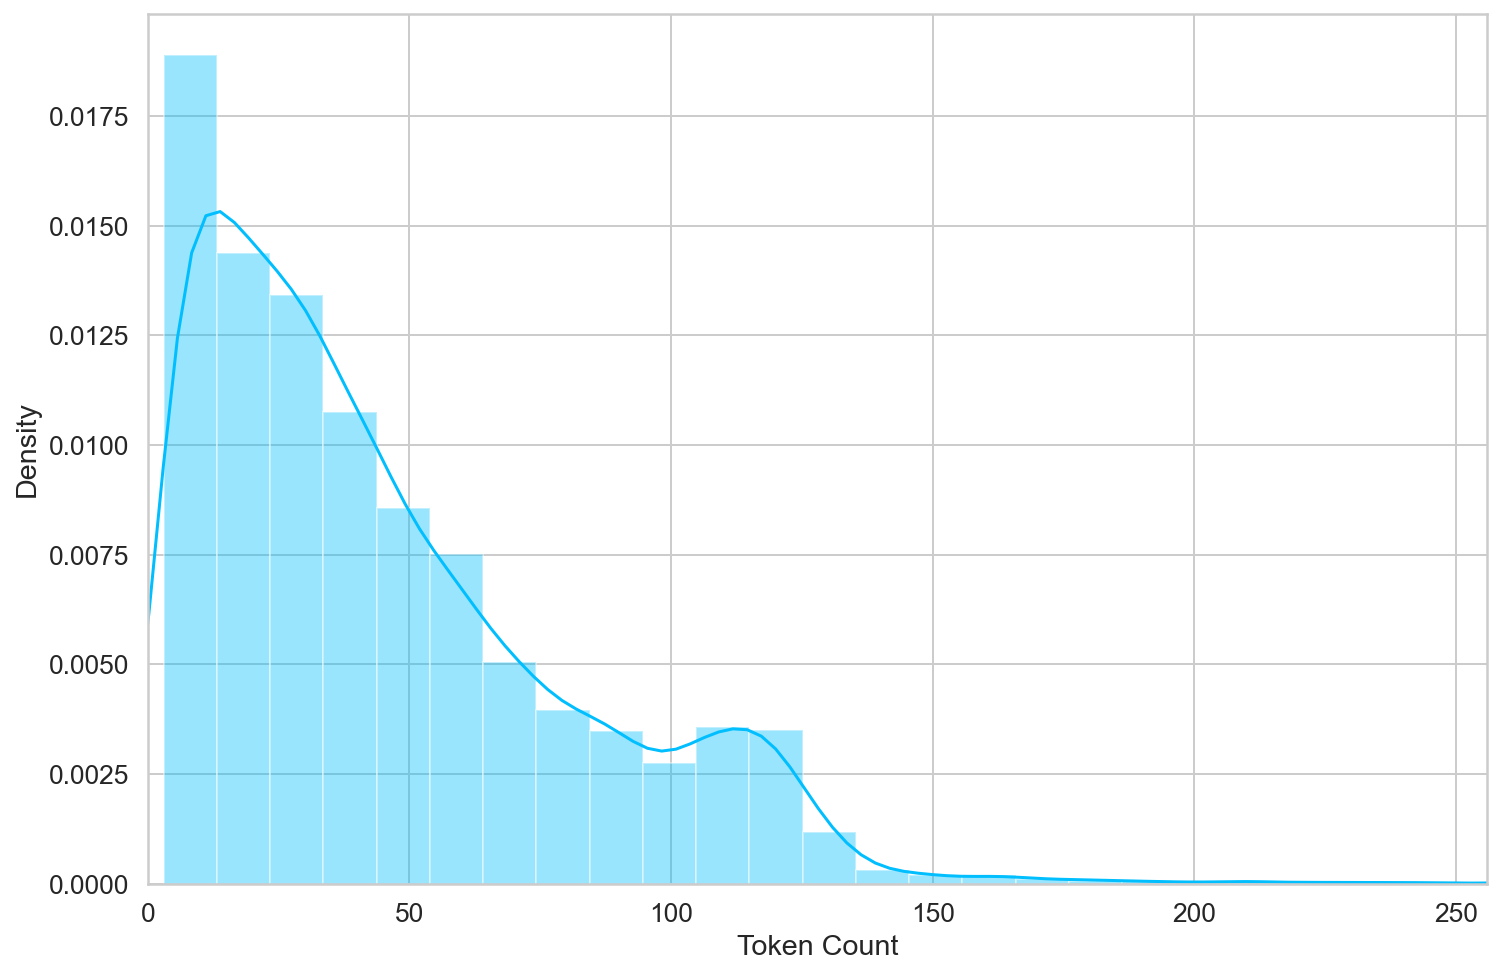

In [26]:
sns.distplot(token_lens)
plt.xlim([0,256])
plt.xlabel('Token Count')

In [27]:
MAX_LEN = 160

In [28]:
class GPReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.reviews)
    
    
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
    
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens = True,
            max_length = self.max_len,
            return_token_type_ids = False,
            pad_to_max_len = True,
            return_attentnio_mask = True,
            return_tensors = 'pt',
        )
        
        return {
            'review_text': review,
            'input_ids':encoding['input_ids'].flatten(),
            'attention_mask':encoding['atttention_mask'].flatten(),
            'targets':torch.tensor(target, dtpye = torch.long)
        }
    

In [29]:
df_train, df_test = train_test_split(
    df,
    test_size = 0.1,
    random_state = RANDOM_SEED
)
df_val, df_test = train_test_split(
    df_test,
    test_size = 0.5,
    random_state = RANDOM_SEED
)

In [30]:
df_train.shape, df_val.shape, df_test.shape

((14171, 12), (787, 12), (788, 12))

In [31]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        
        reviews = df.content.to_numpy(),
        targets = df.sentiment.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
    )
    
    return DataLoader(
        ds,
        batch_size = batch_size,
        num_workers = 4
    )

In [32]:
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
data = next(iter(train_data_loader))
data.keys()

In [33]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [36]:
last_hidden_state, pooled_output = bert_model(
    input_ids = encoding['input_ids'],
    attention_mask = encoding['attention_mask']
)

In [37]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [40]:
bert_model.config.hidden_size

768

In [41]:
pooled_output.shape

torch.Size([1, 768])

In [42]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids = input_ids,
            attention_mask = attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [43]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [44]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

NameError: name 'data' is not defined